## Exploring the Results from Cloud Vision

Import statements

In [32]:
import matplotlib
import matplotlib.pylab as plt
import pandas as pd
import json
import os

In [19]:

dataset_dir = os.path.expanduser("~") + "/datasets/handwriting/IAM_Handwriting_Top50/"
images_dir = dataset_dir + "data_subset/"
analysis_dir = dataset_dir + "gcloud_analysis/"

fullTextAnnotationDict = {}

for filename in os.listdir(analysis_dir):
    f = os.path.join(analysis_dir, filename)
    
    with open(f, encoding='utf-8', errors='ignore') as file: 
        try :
            js = json.load(file)
            
            fullTextAnnotationDict[filename] = js['responses'][0]['fullTextAnnotation']
        except:
            print("Error processing: ", filename)

Error processing:  m06-031-s03-00.json
Error processing:  b06-023-s00-02.json
Error processing:  g06-018c-s01-00.json
Error processing:  n06-123-s03-00.json
Error processing:  g06-042i-s01-00.json
Error processing:  g06-089-s02-03.json
Error processing:  g06-042g-s01-00.json
Error processing:  a01-058u-s03-00.json
Error processing:  c06-052-s03-00.json
Error processing:  a01-058u-s01-00.json
Error processing:  g06-011j-s04-00.json
Error processing:  p03-112-s05-00.json
Error processing:  c03-087a-s01-03.json
Error processing:  a05-017-s03-00.json
Error processing:  j06-008-s02-00.json
Error processing:  g06-011l-s01-00.json
Error processing:  r06-097-s03-01.json
Error processing:  a01-102u-s03-00.json
Error processing:  g06-050n-s02-00.json
Error processing:  g06-011f-s05-00.json
Error processing:  a06-134-s01-00.json
Error processing:  g06-018n-s00-03.json
Error processing:  m06-031-s02-00.json
Error processing:  d06-063-s00-02.json
Error processing:  n06-163-s02-00.json
Error process

In [20]:
len(fullTextAnnotationDict)

4866

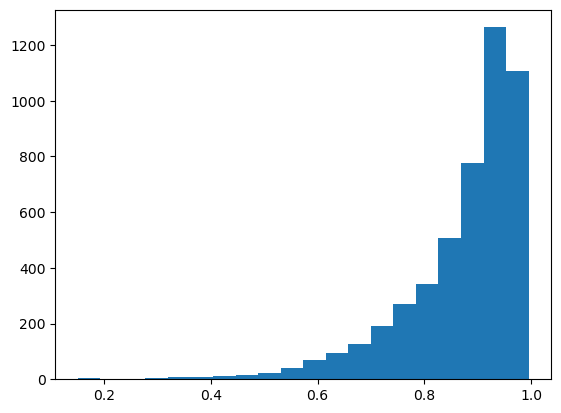

In [40]:
confidence = [x['pages'][0]['confidence'] for x in fullTextAnnotationDict.values()]
cpd = pd.DataFrame(confidence)
# print(len(confidence))
plt.hist(cpd.values, bins=20)
plt.show()